# **Example usage**

Here we will demonstrate how to use `pyadps` in a Jupyter Notebook.

In [452]:
# Load important Python libraries.
import numpy as np
import pyadps
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [14, 4]

## 1. **Read and access data**
The `ReadFile` module reads raw ADCP binary files without modifying the data. Units and scale factors remain as provided by RDI. Refer to RDI Manual for more details.


In [453]:
# Read the file
ds = pyadps.ReadFile('demo.000')

In [454]:
# Listing data from velocity[beams, cells, ensembles]
ds.velocity.data[0, 0, 300:310]

array([ -61,  -52,  -54, -104, -145, -157, -153,  -93, -103, -122],
      dtype=int16)

In [455]:
# Listing other attributes of velocity
print('Velocity units: ', ds.velocity.unit)
print('Missing values: ', ds.velocity.missing_value)

Velocity units:  mm/s
Missing values:  -32768


#### **Depth and time axis** 
An additional depth and time axes are made available to aid in plotting. The time axis is stored as Numpy `datetime64` data type. The depth axis is computed based on the mean depth of the transducer and is stored in *meters*. The actual depth of the transducer is stored in *dm* by RDI (`ds.depth_of_transducer.unit`).

**<span style="color:red">WARNING! </span>** If the mooring has large oscillations, the depth cells may require corrections. Use the `regrid` function to correct the depth axis.

In [456]:
print(ds.time[0:5])


0   2017-10-11 22:00:00
1   2017-10-11 23:00:00
2   2017-10-12 00:00:00
3   2017-10-12 01:00:00
4   2017-10-12 02:00:00
dtype: datetime64[ns]


In [457]:
print(ds.depth[0:5])

[416.04 400.04 384.04 368.04 352.04]


#### **Plotting the data using Matplotlib**
Plots are displayed here using the `Matplotlib` Python package. Default plotting functionality is planned for inclusion in a future release.

In [458]:
X, Y = np.meshgrid(ds.time, ds.depth)
#  Build a plot function
def fillplot(data, beam=0):
    X, Y = np.meshgrid(ds.time, ds.depth)
    levels = np.arange(-150, 150, 20)
    cs = plt.contourf(X, Y, data[beam, :, :]/10, 
                  cmap ="coolwarm", levels=levels, extend="both") 
    ax = cs.axes
    ax.invert_yaxis()
    plt.title("Zonal Velocity")
    plt.colorbar(cs)
    plt.show()

**Note:** The default missing velocity value in the RDI file is -32768. It should be replaced with `np.nan` to prevent it from being displayed in the plot.

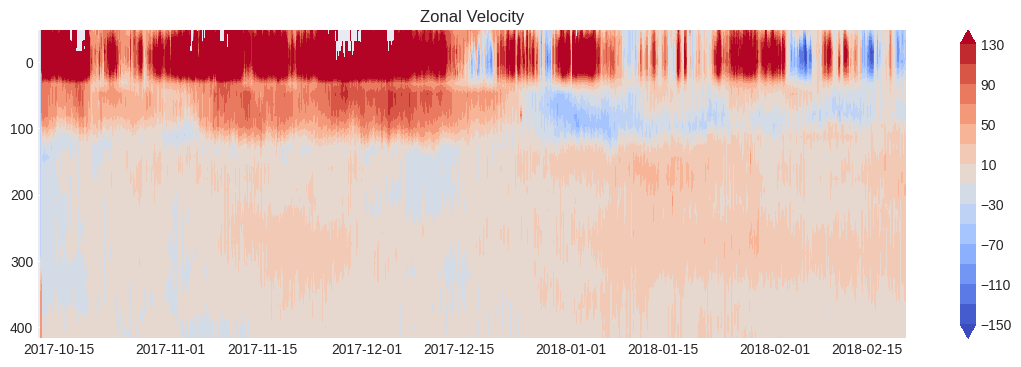

In [459]:
# Display Velocity data from Beam 1 (Zonal Velocity in Earth Co-ordinates)
# Convert the missing value to N
velocity = ds.velocity.data
missing = int(ds.velocity.missing_value)
velocity = np.where(velocity == missing, np.nan, velocity)

fillplot(velocity)

#### **List other data sets**

All ensemble-dependent data (or time-dependent data) can be accessed directly and are also available in either fixedleader or variableleader. Data such as Velocity, Echo Intensity, Correlation, and Percent Good are 3D arrays, varying as functions of beams, cells, and ensembles. 

In [460]:
# List of available data types, attributes and methods
list(vars(ds).keys())[0:10]

['fileheader',
 'fixedleader',
 'variableleader',
 'velocity',
 'correlation',
 'echo',
 'percentgood',
 'time',
 'depth',
 'filename']

In [461]:
# An example to access variable leader data

temp = ds.temperature

# This also works!
# temp = ds.variableleader.temperature 

print(temp.description)


Contains the temperature of the water at the transducer head (ET command). This value may be a manual setting or a reading from a temperature sensor.


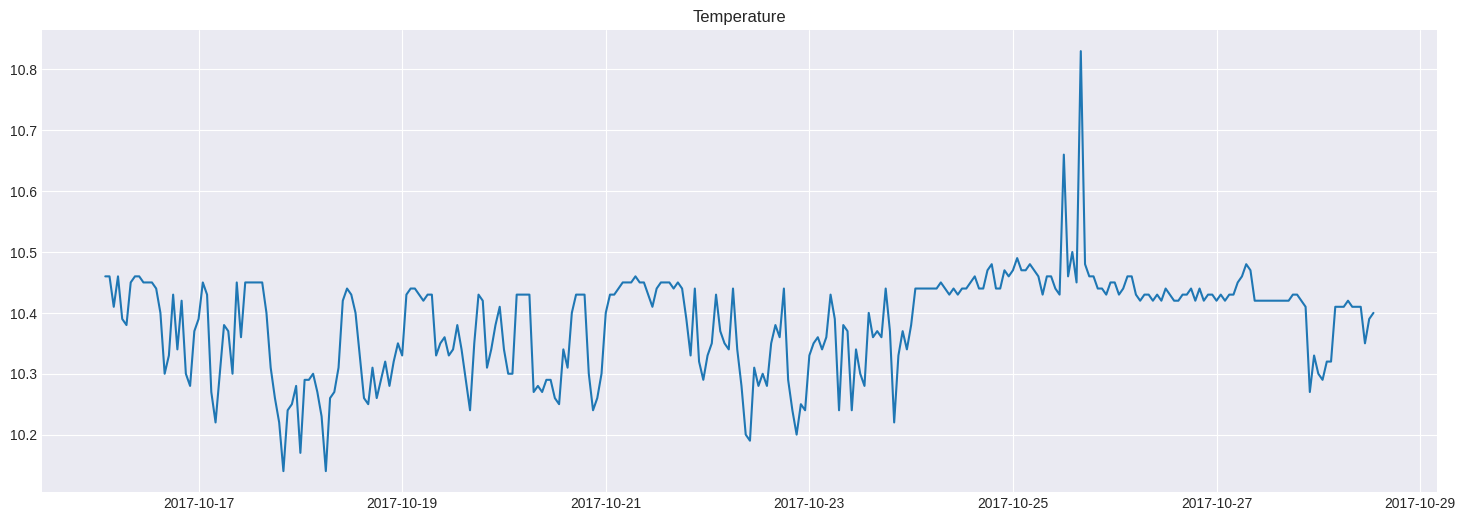

In [462]:
# Plotting data
# Temperature data are stored in a binary file without decimals or scaled by 100.
# Example: Instead of saving 25.34°C, the value 2534 is stored. Multiply by scale factor to get actual values in degrees
plt.figure(figsize = (18,6))
plt.plot(ds.time[100:400], temp.data[100:400]*temp.scale)
plt.title("Temperature")
plt.show()

In [463]:
# Display available attributes for temperature
vars(temp).keys()

dict_keys(['index', 'unit', 'scale', 'byte', 'type', 'command', 'valid_min', 'valid_max', 'long_name', 'description', 'data'])

#### Checking Available Sensors

In [464]:
ds.ez_sensor(field='avail')

{'Sound Speed': False,
 'Depth Sensor': True,
 'Heading Sensor': True,
 'Pitch Sensor': True,
 'Roll Sensor': True,
 'Conductivity Sensor': False,
 'Temperature Sensor': True}

## **2. Process data**

Here we show how to use PyADPS functions to process the data. All processing steps are not displayed here.

### **Create Mask File**

To process the data, it is recommended to create a mask dataset. This ensures the original data is preserved, except for velocity corrections and regridding.

In [465]:
default_mask = pyadps.default_mask(ds)
mask = np.copy(default_mask)

The default mask will contain missing data based on pre-deployment Quality Control settings.

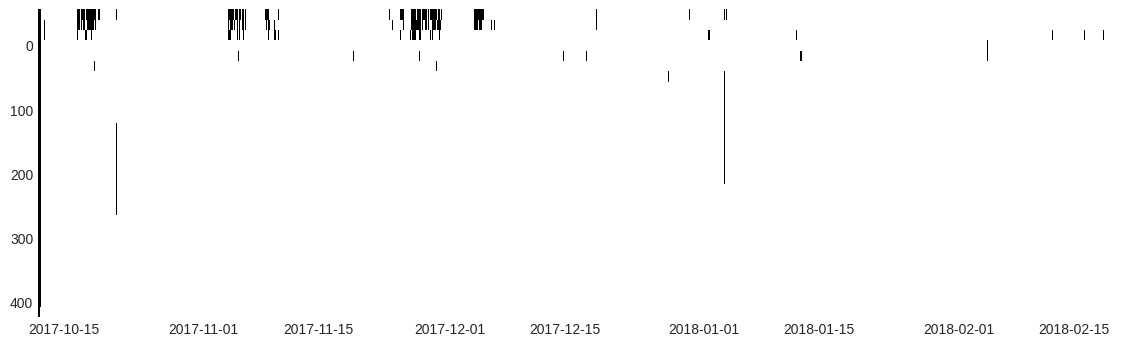

In [466]:
cs = plt.pcolor(X, Y, mask)
ax = cs.axes
ax.invert_yaxis()
plt.show()

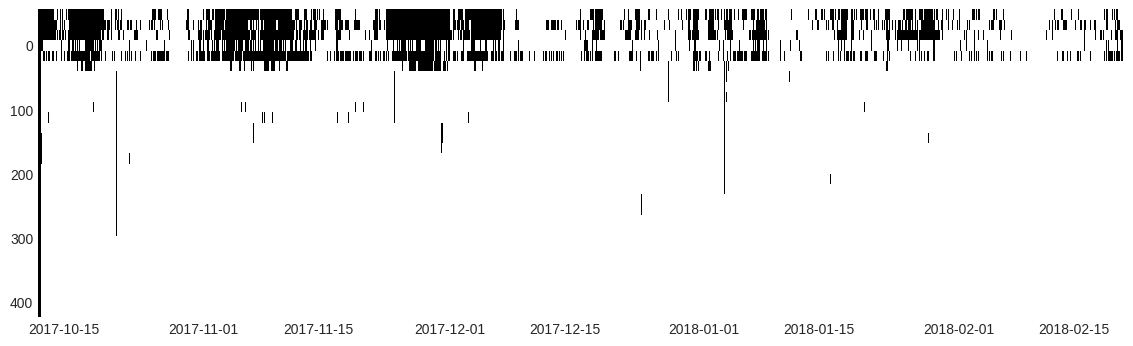

In [467]:
# Apply QC Thresholds
mask = pyadps.pg_check(ds, mask, 50)
mask = pyadps.correlation_check(ds, mask, 64)
mask = pyadps.echo_check(ds, mask, 30)
mask = pyadps.ev_check(ds, mask, 200)
mask = pyadps.false_target(ds, mask, 50, threebeam=True)

cs = plt.pcolor(X, Y, mask)
ax = cs.axes
ax.invert_yaxis()
plt.show()

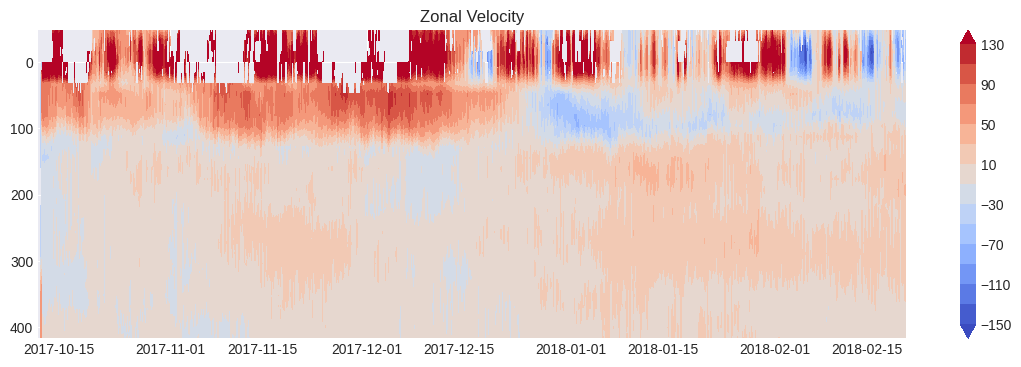

In [468]:
# Apply mask to the velocity data
velocity = np.where(mask == 1, np.nan, velocity)
fillplot(velocity)

Bad data owing surface scattering can be masked using `side_lobe_beam_angle`.

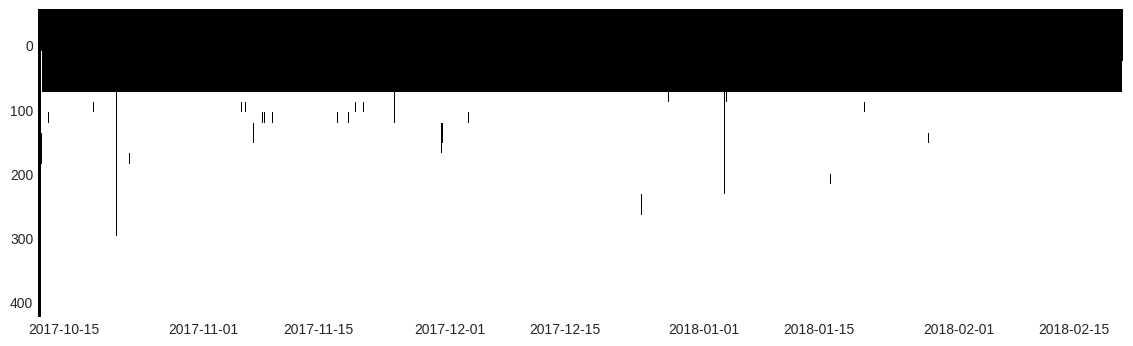

In [469]:
mask = pyadps.side_lobe_beam_angle(ds, mask)
cs = plt.pcolor(X, Y, mask)
ax = cs.axes
ax.invert_yaxis()
plt.show()


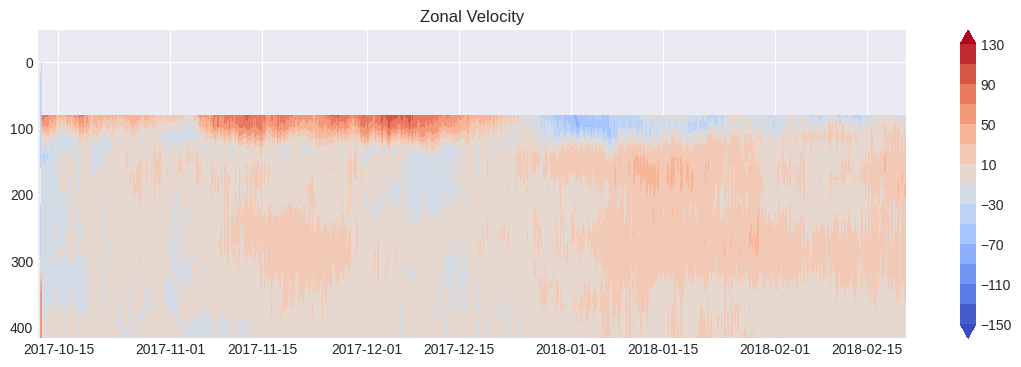

In [470]:
# Display masked data after cutting the surface bins
velocity = np.where(mask == 1, np.nan, velocity)
fillplot(velocity)
